<a href="https://colab.research.google.com/github/wmmandela/Mandela/blob/main/Fake_News_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

STEPS:
1. Import Libraries
2. Load and Combine Datasets
3. Text Cleaning and Processing
4. Identify Fake News Pattern
5. Keyword Detection
6. Vectorization
7. Train-test Split and Modelling
8. Real World Testing
9. Evaluation

1. Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix


2. Load and Combine Datasets

In [ ]:
# Upload and read your datasets
df1 = pd.read_excel('/content/Fake News (hinnews.com) Questionable.xlsx')
df2 = pd.read_excel('/content/Fake News (mzanzi stories) Fake.xlsx')
df3 = pd.read_excel('/content/Fake News (sa-news.com) Fake.xlsx')

# Combine into one
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
combined_df.head()


,"{""published_date"": ""","May 1, 2019",""",""title"": ""","House thief beaten to death, Butterworth",""",""text"": ""","A 28-year-old Butterworth man, who was allegedly part of a gang that terrorised Walter Sisulu University students living in a privately-owned residence, was beaten to death by unknown people. The man was found inside the student digs, but reportedly died after being admitted to hospital. Butterworth police spokesman Captain Jackson Manatha said the incident happened in the early hours of Sunday at a Zazulwana-based residence. University spokeswoman Yonela Tukwayo said they were aware of the incident. \""No details are available about the incident and the university is relying on the police for more information,\"" she said. The caretaker of the residence, who asked not to be named, said she heard a commotion at about 2.30am on Sunday, which woke her up. \""I stayed inside for a while as I was scared to go outside. Eventually I went out. I saw a body of a man with injuries. \""I then called the police.\"" She said when the police arrived at the residence, the man was still alive. \""I then later received a call from police telling me that the man had passed away in hospital,\"" she said. It is alleged that the man had attempted to break-in. The caretaker said it was not the first time there had been a robbery at that residence. She said, after midnight on Tuesday, two guys entered the residence and stole meat and a cellphone. A female student living at the off-campus residence said they lived in fear. \""A week does not pass without hearing of a burglary in these residences,\"" she said. Student leadership said they were concerned about the safety of students. SRC’s Lonwabo Nkosana said they were worried about the university \""forcefully approving places that do not meet standards to be student residences\"". \""Some of these places are not even burglar proofed. Even the security guards are not trained in security,\"" he said. The incident happened less than three weeks after students at the Mthatha campus’ Zamukulungisa Site student residents allegedly took the law into their own hands and killed a fellow student accused of stealing laptops.",""",""url"": """,http://www.hinnews.com/za/national-news/house-thief-beaten-to-death-butterworth/,""",""medium"": """,hinnews.com,...,2020-04-02 00:00:00,Video of Masego - Leaked trending video of Masego,A Hoax old video which is believed to be a video of masego That video existed on P-0rn sites long time ago. Masego (The Trending SA woman) is a fake woman who trended on Twitter with people amused by the size of her vag*na after her s*x video was allegedly leaked. The video however turned to be an old po*n video. Masego turned to be a hoax meant as an April's Fools Day. You can watch the video 1 HERE You can watch the video 2 HERE,https://www.mzansistories.com/2020/04/video-of-masego-leaked-trending-video.html,mzanzi stories,11/09/2020,"VIDEO: Bystanders Stop Self Confessed Muslim Pedophile’s Child Kidnap Attempt at Northcliff, Randburg Restaurant!","Thanks to the quick action of bystanders, the brazen kidnap attempt of a young child who was eating with her family in an open air restaurant in Northcliff, Randburg, in broad daylight, by a muslim pedophile was stopped and the criminal arrested! Footage received shows the muslim pedo jumping the railing and trying to grab the child, but thanks to some alert bystanders he was accosted before he could even get the child out the chair. Afterwards when lying on the ground in handcuffs he was shouting Alluhah Ahkbar and Islamic phrases, after which he confesses to enjoying being a pedophile, with bystanders commenting that his \""Allah\"" won’t help him now… Video as received. If the video does not load above, watch it here: https://youtu.be/a8PUDw3rOtA",https://sa-news.com/video-bystanders-stop-self-confessed-muslim-pedophiles-child-kidnap-attempt-at-northcliff-randburg-restaurant/,sa-news
0,"{""published_date"": ""","May 1,

3. Text Cleaning and Processing

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text):
    if pd.isnull(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'(http|https|www)\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply to a column with text (adjust column name based on your dataset structure)
combined_df['text'] = combined_df.iloc[:, 0].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


4. Identify Fake News Patterns

In [ ]:
clickbait_keywords = [
    "shocking", "revealed", "you won’t believe", "what happened next",
    "this will blow your mind", "caught on camera", "exposed", "leaked",
    "jaw-dropping", "breaking", "unbelievable", "must see", "exclusive"
]

def detect_clickbait(text):
    if pd.isna(text):
        return 0
    text = text.lower()
    for keyword in clickbait_keywords:
        if keyword in text:
            return 1
    return 0

# Assume there's a 'text' or 'headline' column — if not, replace with appropriate column
combined_df["clickbait_flag"] = combined_df.iloc[:, 0].apply(detect_clickbait)
combined_df["clickbait_flag"].value_counts()



,count
clickbait_flag,
0,591


5. Keyword Detection

In [ ]:
# Define lists of keywords for basic classification
fake_keywords = [
    'shocking', 'unbelievable', 'you won’t believe', 'miracle',
    'secret', 'amazing', 'surprising', 'hoax', 'scandal',
    'revealed', 'exposed', 'truth about', 'click here', 'must see'
]

def keyword_based_classifier(text):
    text = str(text).lower()  # Convert to string and lowercase
    score = sum(1 for word in fake_keywords if word in text)
    # Arbitrary threshold: if 2 or more keywords found, classify as fake
    return 1 if score >= 2 else 0

def analyze_and_classify(filepath):
    """Analyzes an Excel file, detects relevant columns, and performs keyword-based classification."""
    df = pd.read_excel(filepath)

    # Assume the first column with text data is the news article column
    text_column = df.select_dtypes(include=['object']).columns[0]

    # Apply the classifier to the selected text column
    df['keyword_prediction'] = df[text_column].apply(keyword_based_classifier)

    # Assume a column named 'news_category' contains the true labels

    if 'news_category' not in df.columns:
      df['news_category'] = 'Fake'

    df['news_category_encoded'] = df['news_category'].apply(lambda x: 1 if x == 'Fake' else 0)
    print(f"Keyword Classifier Evaluation for {filepath}:")
    print(classification_report(df['news_category_encoded'], df['keyword_prediction']))

    return df









6. Vectorization

In [ ]:
df1 = analyze_and_classify('/content/Fake News (hinnews.com) Questionable.xlsx')
df2 = analyze_and_classify('/content/Fake News (mzanzi stories) Fake.xlsx')
df3 = analyze_and_classify('/content/Fake News (sa-news.com) Fake.xlsx')

# Combine the DataFrames
combined_df = pd.concat([df1, df2, df3], ignore_index=True)

# Assuming the first column with text data is the news article column
text_column = combined_df.select_dtypes(include=['object']).columns[0]

combined_df["clickbait_flag"] = combined_df[text_column].apply(detect_clickbait)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(combined_df[text_column])




Keyword Classifier Evaluation for /content/Fake News (hinnews.com) Questionable.xlsx:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00      99.0

    accuracy                           0.00      99.0
   macro avg       0.00      0.00      0.00      99.0
weighted avg       0.00      0.00      0.00      99.0

Keyword Classifier Evaluation for /content/Fake News (mzanzi stories) Fake.xlsx:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     276.0

    accuracy                           0.00     276.0
   macro avg       0.00      0.00      0.00     276.0
weighted avg       0.00      0.00      0.00     276.0

Keyword Classifier Evaluation for /content/Fake News (sa-news.com) Fake.xlsx:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

7. Train-test Split and Modelling

In [ ]:
y = combined_df['news_category_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


8. Real World Testing

In [ ]:
!pip install datasets
from datasets import load_dataset

  # Load FakeNewsNet dataset
  # Instead of 'fnn', use 'politifact' or 'gossipcop'
dataset = load_dataset("liar")

  # Preprocess the new dataset
def preprocess_text(example):
    if isinstance(example["statement"], np.ndarray):
        # If it's an array, handle potential NaN values within the array
        example["statement"] = ["" if pd.isnull(x) else x for x in example["statement"]]
        example["statement"] = " ".join(example["statement"])  # Convert to a string


    return example

dataset = dataset.map(preprocess_text, batched=True)

  # Extract features and news_category_encoded
X_new = vectorizer.transform(dataset["train"]["statement"])
  # Assuming "news_category" column in dataset (Adjust if different)
y_new = dataset["train"]["label"]

  # Predict on the new dataset
y_pred_new = model.predict(X_new)

  # Evaluate performance
print(classification_report(y_new, y_pred_new))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1998
           1       0.21      1.00      0.34      2123
           2       0.00      0.00      0.00      1966
           3       0.00      0.00      0.00      1683
           4       0.00      0.00      0.00      1657
           5       0.00      0.00      0.00       842

    accuracy                           0.21     10269
   macro avg       0.03      0.17      0.06     10269
weighted avg       0.04      0.21      0.07     10269



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


9. Evaluation


Statistical Representation:
classification
Real    591
Name: count, dtype: int64


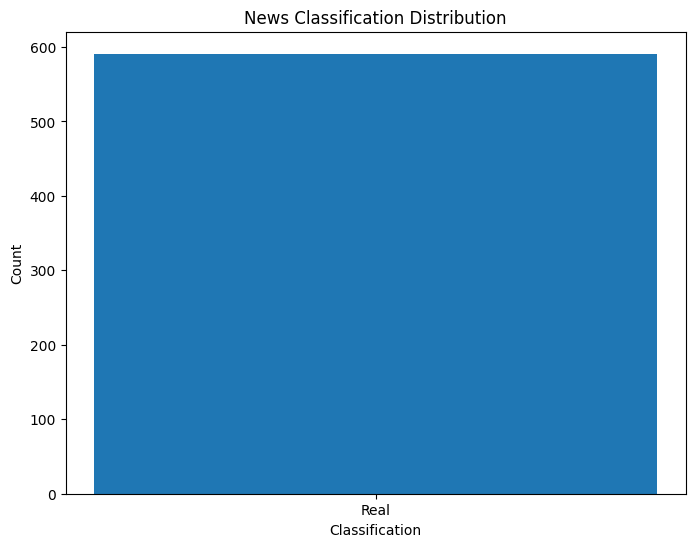

In [ ]:
# Define a function to classify news based on clickbait and fake words
def classify_news(row):
    if row['clickbait_flag'] == 1 and row['keyword_prediction'] == 1:
        return "Fake"  # Classified as fake if both clickbait and fake keywords are present
    else:
        return "Real"  # Otherwise, classified as real


# Apply the classification function to the combined DataFrame
combined_df['classification'] = combined_df.apply(classify_news, axis=1)

# Calculate and display the statistical representation
classification_counts = combined_df['classification'].value_counts()
print("\nStatistical Representation:")
print(classification_counts)

# Create a bar plot for visualization
plt.figure(figsize=(8, 6))
plt.bar(classification_counts.index, classification_counts.values)
plt.title("News Classification Distribution")
plt.xlabel("Classification")
plt.ylabel("Count")
plt.show()
